# How `BGLS` works

Here we describe how the gate-by-gate sampling algorithm introduced in *How to simulate quantum measurement without computing marginals ([Phys. Rev. Lett.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.128.220503)) ([arXiv](https://arxiv.org/abs/2112.08499))* (hereafter [1]) works.

In [1]:
"""Setup."""
import itertools

import matplotlib.pyplot as plt
import numpy as np
import cirq

Consider the following three-qubit GHZ circuit.

In [2]:
"""Create a three-qubit GHZ circuit."""
nqubits = 3
qubits = cirq.LineQubit.range(nqubits)

circuit = cirq.Circuit(
    cirq.H.on(qubits[0]),
    [cirq.CNOT.on(qubits[i], qubits[i + 1]) for i in range(nqubits - 1)]
)
circuit

0: ───H───@───────
          │
1: ───────X───@───
              │
2: ───────────X───

## Qubit-by-qubit sampling

The "usual" way to sample from this circuit is to 

1. Compute the final wavefunction $|\psi\rangle = (|000\rangle + |111\rangle) / \sqrt{2}$.
1. Sample a bit $b_1$ from the probability distribution of the first qubit.
1. Sample a bit $b_2$ from the probability distribution of the second qubit conditional on the first qubit being in the state $|b_1\rangle$.
1. Sample a bit $b_3$ from the probability distribution of the third qubit condition on the first two qubits being in the state $|b_1 b_2 \rangle$.

Following [1], we refer to this algorithm as *qubit-by-qubit* sampling since it iterates over qubits. We can implement this for our example circuit as follows.


In [3]:
"""Implement qubit-by-qubit sampling for the example circuit."""
bits = [0, 1]

psi = circuit.final_state_vector()
rho = np.outer(psi, psi.conj()).reshape([2] * 2 * nqubits)

rho0 = cirq.partial_trace(rho, keep_indices=[0])
bit0 = np.random.choice(bits, p=np.diag(rho0).real / np.sum(np.diag(rho0).real))

rho1 = cirq.partial_trace(rho, keep_indices=[0, 1])[bit0, bit0]
bit1 = np.random.choice(bits, p=np.diag(rho1).real / np.sum(np.diag(rho1).real))

rho2 = rho[bit0, bit0][bit1, bit1]
bit2 = np.random.choice(bits, p=np.diag(rho2).real / np.sum(np.diag(rho2).real))

print("Sampled bitstring:", "".join([str(b) for b in (bit0, bit1, bit2)]))

Sampled bitstring: 000


## Gate-by-gate sampling

In contrast, the `BGLS` sampling algorithm iterates over gates and updates the bitstring after each application of a gate. Because it iterates over gates, it's referred to as "gate-by-gate" sampling. Check out the following video for a visual walkthrough of the algorithm.

### Video explainer

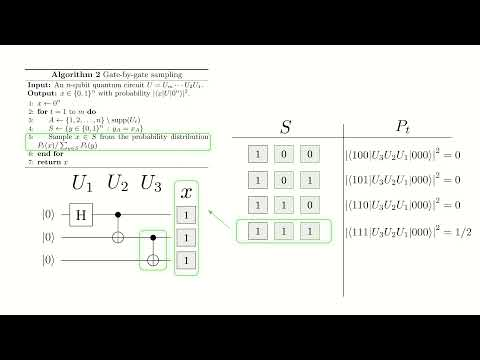

In [4]:
from IPython.display import YouTubeVideo

YouTubeVideo("bkp96JijQKU", width=640, height=360)

### Discussion and example

As shown in the video, the `BGLS` gate-by-gate sampling approach iterates over each gate in the circuit, and for each gate (1) updates the wavefunction $|\psi\rangle$ and (2) updates the bitstring $b$. After all gates we have a final bitstring to return - no need to compute marginal distributions. 

We start with $|\psi\rangle = |0\rangle ^ {\otimes n}$ and $b = 0 ^ n$, shown below.

In [5]:
"""Initialize the wavefunction and bitstring for the BGLS gate-by-gate sampling algorithm."""
bitstring = ["0"] * nqubits
state = cirq.StateVectorSimulationState(qubits=qubits, initial_state=0)

print("Initial bitstring:", bitstring)
print("Initial wavefunction:", state.target_tensor.reshape(2 ** nqubits))

Initial bitstring: ['0', '0', '0']
Initial wavefunction: [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


Now we start looping through gates in the circuit. Below we grab the first gate and determine its support.

In [6]:
"""Grab the first gate and determine its support."""
op = list(circuit.all_operations())[0]
print("Gate is:", op)

qubit_to_index = {q: i for i, q in enumerate(qubits)}
support = {qubit_to_index[q] for q in op.qubits}
print("Support is:", support)

Gate is: H(q(0))
Support is: {0}


The support of the gate determines which bits in the bitstring we update. Since the support is the 0th qubit, we update the 0th bit. As in the above video, you can think about placing a "wildcard" (?) on each bit in the support of the gate, where the wildcard ? is either $0$ or $1$. In Python, we can iterate the new candidate bitstrings as follows.

In [7]:
"""Iterate the new candidate bitstrings."""
candidate_bitstrings = list(itertools.product(
    *[["0", "1"] if i in support else [b] 
      for i, b in enumerate(bitstring)]
))
print(candidate_bitstrings)

[('0', '0', '0'), ('1', '0', '0')]


Now we determine which of the candidate bitstrings to choose by computing amplitudes (which are squared to get probabilities) of the updated wavefunction. Using a state vector simulator, we can update the wavefunction with `cirq.protocols.act_on` and compute amplitudes by simply indexing the wavefunction.

In [8]:
"""Update the bitstring to one of the candidate bitstrings."""
cirq.protocols.act_on(op, state)

probs = [abs(state.target_tensor.reshape(2 ** nqubits)[int("".join(b), 2)]) ** 2 for b in candidate_bitstrings]

index = np.random.choice(range(len(candidate_bitstrings)), p=probs / sum(probs))
bitstring = candidate_bitstrings[index]

print("Bitstring is now:", bitstring)

Bitstring is now: ('1', '0', '0')


### Putting it all together

Now that we've implemented one step, we can put this in a loop over all operations as in the following function.

In [9]:
def sample(circuit: cirq.Circuit) -> str:
    qubits = circuit.all_qubits()

    bitstring = ["0"] * nqubits
    state = cirq.StateVectorSimulationState(qubits=qubits, initial_state=0)

    qubit_to_index = {q: i for i, q in enumerate(qubits)}
    for op in circuit.all_operations():
        # Determine the candidate bitstrings to sample.
        support = {qubit_to_index[q] for q in op.qubits}
        candidate_bitstrings = list(itertools.product(
            *[["0", "1"] if i in support else [b] 
            for i, b in enumerate(bitstring)]
        ))

        # Compute probability of each candidate bitstring.
        cirq.protocols.act_on(op, state)
        probs = [abs(state.target_tensor.reshape(2 ** nqubits)[int("".join(b), 2)]) ** 2 for b in candidate_bitstrings]

        # Sample from the candidate bitstrings and update the bitstring.
        index = np.random.choice(range(len(candidate_bitstrings)), p=probs / sum(probs))
        bitstring = candidate_bitstrings[index]

    return "".join(bitstring)

This is the core of the `bgls.Simulator`! We can check it produces the expected distribution by sampling many times. For an inductive proof of the algorithm's correctness, see [1].

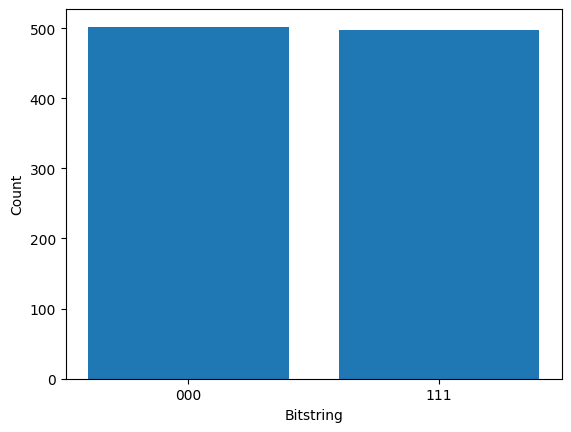

In [10]:
samples = [sample(circuit) for _ in range(1000)]

plt.bar(*np.unique(samples, return_counts=True), align="center")
plt.xlabel("Bitstring")
plt.ylabel("Count");

## References

[1] *How to simulate quantum measurement without computing marginals ([Phys. Rev. Lett.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.128.220503)) ([arXiv](https://arxiv.org/abs/2112.08499))*